In [1]:
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/classification_models.py --output classification_models.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   3350      0 --:--:-- --:--:-- --:--:--  3350
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4155  100  4155    0     0  22101      0 --:--:-- --:--:-- --:--:-- 22101
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4358  100  4358    0     0  26573      0 --:--:-- --:--:-- --:--:-- 26573


## Import modules

In [2]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

from brain_tumor_dataset import BrainTumorDataset     # Dataset
import classification_models as models                # Module for models
from trainer import Trainer, ModelCheckpoint          # Trainer Class

## Preprocessing Dataset | (from .mat to .npy)

Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

Convert .mat to .npy

In [4]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    img = np.array(f.get('cjdata/image'), dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1

Save labels in a CSV file

In [5]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

Remove MAT files

In [6]:
!rm -rf tmp_dataset

## Functions Tools

In [7]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

def plot_train_loss(model_dic, label=None, legend='upper center', model_name=None):
  """
     This method allows you to view the history of the loss function per epoch
  """
  train_loss_history = model_dic['train_loss_history']
  x_values = range(1, len(train_loss_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Training loss')
  else:
    plt.title('Training loss using ' + model_name)

  if label is not None:
    plt.plot(x_values, train_loss_history, '-o', label=label)
    plt.legend(loc=legend)
  else:
    plt.plot(x_values, train_loss_history, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(model_dic, model_name=None):
  """
     This method allows you to view the historical accuracy per epoch
  """  
  train_acc_history = model_dic['train_acc_history']
  val_acc_history = model_dic['val_acc_history']
  x_values = range(1, len(train_acc_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Accuracy')
  else:
    plt.title('Accuracy using ' + model_name )
  plt.plot(x_values, train_acc_history, '-o', label='train')
  plt.plot(x_values, val_acc_history, '-o', label='val')
  plt.ylabel('Accuracy')  
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

def plot_metric_from_array(models_dic, plot_name, legend='lower right', plot_data='both', metric='acc'):
  """
     This method allows to visualize the history of the validation 
     accuracy of several models per epoch
  """
  if metric not in ['acc', 'loss']:
    raise ValueError(f"metric:'{metric}' is not a valid value, use: 'acc', 'loss'")
  name = 'accuracy' if metric == 'acc' else 'loss'

  if plot_data == 'both':
    plt.subplots(figsize =(12, 5)) 
    ### Training subplot
    plt.subplot(1, 2, 1) 
  else:
    plt.figure(figsize=(7, 5))

  if plot_data == 'both' or plot_data == 'train':
    for model_name, model_dic in models_dic.items():
      train_acc_history = model_dic['train_'+metric+'_history']
      x_values = range(1, len(train_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Training '+name)
      else:
        plt.title('Training '+name+' using ' + plot_name )
      plt.plot(x_values, train_acc_history, '-o', label=model_name)
    plt.ylabel(name.capitalize())
    plt.xlabel('Epoch')
    plt.legend(loc=legend)

  if plot_data == 'both':
    ### Validation subplot
    plt.subplot(1, 2, 2)  
  if plot_data == 'both' or plot_data == 'val':  
    for model_name, model_dic in models_dic.items():
      val_acc_history = model_dic['val_'+metric+'_history']
      x_values = range(1, len(val_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Validation '+name)
      else:
        plt.title('Validation '+name+' using ' + plot_name )
      plt.plot(x_values, val_acc_history, '-o', label=model_name)   
    if plot_data == 'val':
      plt.ylabel(name.capitalize()) 
    plt.xlabel('Epoch')
    plt.legend(loc=legend)
  plt.show()

## Config GPU and Seed

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [9]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

## Load Dataset and Create DataLoaders

In [10]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [11]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [12]:
# Create Loaders
train_dataloader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dataloader))
print('Validation data: ', len(val_dataloader))
print('Test data: ', len(test_dataloader))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


## View Dataset

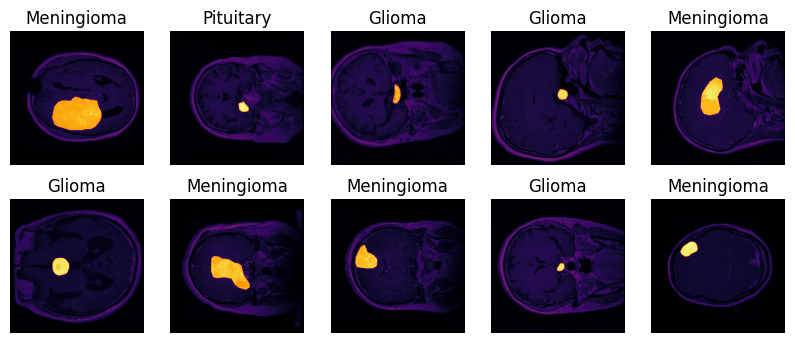

In [13]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
plt.figure(figsize=(10, 4))
for i in range(10):
  index = random.randint(0, len(train_data)-1)
  image, label = train_data[index]
  image = (image*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[label.item()-1]))
  plt.imshow(mask, cmap='inferno')

In [14]:
model = models.SimpleModelWithReLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
simple_model_with_relu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]



Epoch (1/10): train_loss = 0.808239, val_loss= 0.000171, train_acc = 0.669765, val_acc= 0.831148

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25it/s]



Epoch (2/10): train_loss = 0.367271, val_loss= 0.000045, train_acc = 0.866594, val_acc= 0.913115

val_loss changed (0.000171 -> 0.000045). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.15it/s]



Epoch (3/10): train_loss = 0.244288, val_loss= 0.000017, train_acc = 0.909787, val_acc= 0.895082

val_loss changed (0.000045 -> 0.000017). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.60it/s]



Epoch (4/10): train_loss = 0.188140, val_loss= 0.000005, train_acc = 0.928923, val_acc= 0.931148

val_loss changed (0.000017 -> 0.000005). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.29it/s]



Epoch (5/10): train_loss = 0.180385, val_loss= 0.000004, train_acc = 0.932203, val_acc= 0.891803

val_loss changed (0.000005 -> 0.000004). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.92it/s]



Epoch (6/10): train_loss = 0.161533, val_loss= 0.000017, train_acc = 0.939858, val_acc= 0.955738



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.58it/s]



Epoch (7/10): train_loss = 0.154362, val_loss= 0.000003, train_acc = 0.942592, val_acc= 0.944262

val_loss changed (0.000004 -> 0.000003). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.19it/s]



Epoch (8/10): train_loss = 0.149925, val_loss= 0.000002, train_acc = 0.946419, val_acc= 0.945902

val_loss changed (0.000003 -> 0.000002). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.33it/s]



Epoch (9/10): train_loss = 0.080052, val_loss= 0.000001, train_acc = 0.971022, val_acc= 0.965574

val_loss changed (0.000002 -> 0.000001). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.99it/s]


Epoch (10/10): train_loss = 0.066023, val_loss= 0.000000, train_acc = 0.975943, val_acc= 0.901639

val_loss changed (0.000001 -> 0.000000). Saving model...



In [15]:
model = models.SimpleModelWithSELU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
simple_model_with_selu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.92it/s]



Epoch (1/10): train_loss = 1.434360, val_loss= 0.000668, train_acc = 0.622745, val_acc= 0.770492

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.08it/s]



Epoch (2/10): train_loss = 0.435382, val_loss= 0.000498, train_acc = 0.833789, val_acc= 0.862295

val_loss changed (0.000668 -> 0.000498). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.63it/s]



Epoch (3/10): train_loss = 0.320344, val_loss= 0.000330, train_acc = 0.885730, val_acc= 0.865574

val_loss changed (0.000498 -> 0.000330). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.96it/s]



Epoch (4/10): train_loss = 0.295783, val_loss= 0.000069, train_acc = 0.891744, val_acc= 0.891803

val_loss changed (0.000330 -> 0.000069). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.68it/s]



Epoch (5/10): train_loss = 0.228972, val_loss= 0.000016, train_acc = 0.917441, val_acc= 0.862295

val_loss changed (0.000069 -> 0.000016). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.83it/s]



Epoch (6/10): train_loss = 0.323663, val_loss= 0.000056, train_acc = 0.887370, val_acc= 0.918033



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.86it/s]



Epoch (7/10): train_loss = 0.214871, val_loss= 0.000031, train_acc = 0.922362, val_acc= 0.814754



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.90it/s]



Epoch (8/10): train_loss = 0.250753, val_loss= 0.000012, train_acc = 0.921268, val_acc= 0.914754

val_loss changed (0.000016 -> 0.000012). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.79it/s]



Epoch (9/10): train_loss = 0.133112, val_loss= 0.000001, train_acc = 0.951340, val_acc= 0.937705

val_loss changed (0.000012 -> 0.000001). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.87it/s]


Epoch (10/10): train_loss = 0.102422, val_loss= 0.000005, train_acc = 0.963368, val_acc= 0.949180



In [16]:
model = models.DeeperModelWithLeakyReLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
deeper_model_with_leakyrelu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.80it/s]



Epoch (1/10): train_loss = 0.877865, val_loss= 0.000160, train_acc = 0.591033, val_acc= 0.708197

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.86it/s]



Epoch (2/10): train_loss = 0.494516, val_loss= 0.000087, train_acc = 0.792783, val_acc= 0.749180

val_loss changed (0.000160 -> 0.000087). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.61it/s]



Epoch (3/10): train_loss = 0.370993, val_loss= 0.000190, train_acc = 0.855659, val_acc= 0.919672



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.75it/s]



Epoch (4/10): train_loss = 0.302917, val_loss= 0.000063, train_acc = 0.889010, val_acc= 0.929508

val_loss changed (0.000087 -> 0.000063). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.94it/s]



Epoch (5/10): train_loss = 0.263111, val_loss= 0.000034, train_acc = 0.909240, val_acc= 0.942623

val_loss changed (0.000063 -> 0.000034). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.31it/s]



Epoch (6/10): train_loss = 0.216316, val_loss= 0.000012, train_acc = 0.927829, val_acc= 0.921311

val_loss changed (0.000034 -> 0.000012). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.88it/s]



Epoch (7/10): train_loss = 0.141103, val_loss= 0.000027, train_acc = 0.952433, val_acc= 0.914754



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.44it/s]



Epoch (8/10): train_loss = 0.145945, val_loss= 0.000105, train_acc = 0.948059, val_acc= 0.931148



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.95it/s]



Epoch (9/10): train_loss = 0.150676, val_loss= 0.000009, train_acc = 0.946966, val_acc= 0.962295

val_loss changed (0.000012 -> 0.000009). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.69it/s]


Epoch (10/10): train_loss = 0.204027, val_loss= 0.000011, train_acc = 0.939311, val_acc= 0.960656



In [17]:
model = models.DeeperModelWithSELU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
deeper_model_with_selu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.82it/s]



Epoch (1/10): train_loss = 0.765977, val_loss= 0.000358, train_acc = 0.658283, val_acc= 0.727869

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.72it/s]



Epoch (2/10): train_loss = 0.378517, val_loss= 0.000609, train_acc = 0.857846, val_acc= 0.875410



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.97it/s]



Epoch (3/10): train_loss = 0.335204, val_loss= 0.000012, train_acc = 0.872608, val_acc= 0.852459

val_loss changed (0.000358 -> 0.000012). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.84it/s]



Epoch (4/10): train_loss = 0.349885, val_loss= 0.000035, train_acc = 0.867141, val_acc= 0.919672



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.74it/s]



Epoch (5/10): train_loss = 0.203810, val_loss= 0.000011, train_acc = 0.922362, val_acc= 0.926230

val_loss changed (0.000012 -> 0.000011). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.86it/s]



Epoch (6/10): train_loss = 0.185373, val_loss= 0.000016, train_acc = 0.926736, val_acc= 0.914754



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.85it/s]



Epoch (7/10): train_loss = 0.164332, val_loss= 0.000027, train_acc = 0.942045, val_acc= 0.927869



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.83it/s]



Epoch (8/10): train_loss = 0.223894, val_loss= 0.000020, train_acc = 0.918535, val_acc= 0.934426



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.73it/s]



Epoch (9/10): train_loss = 0.147310, val_loss= 0.000006, train_acc = 0.946966, val_acc= 0.942623

val_loss changed (0.000011 -> 0.000006). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.68it/s]



Epoch (10/10): train_loss = 0.120531, val_loss= 0.000005, train_acc = 0.959541, val_acc= 0.952459

val_loss changed (0.000006 -> 0.000005). Saving model...



<ipython-input-7-10f1849b0732>:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


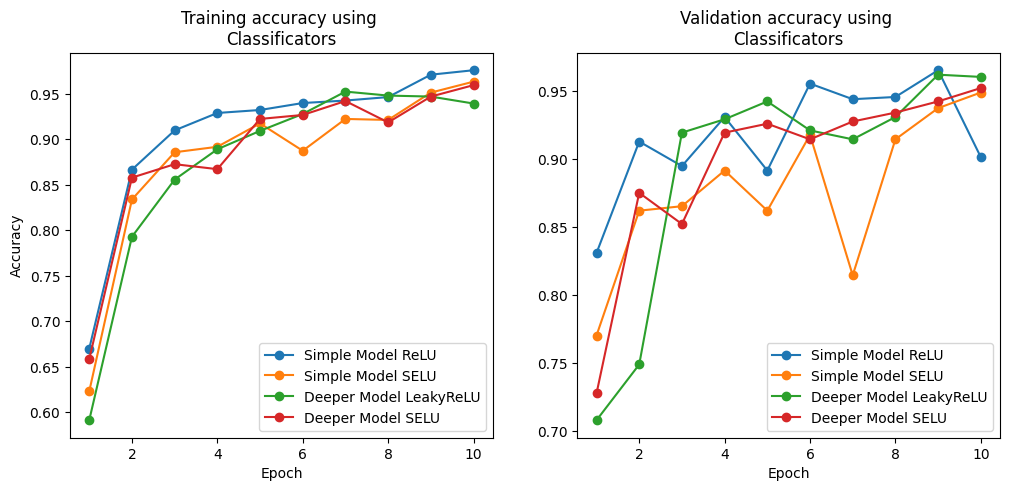

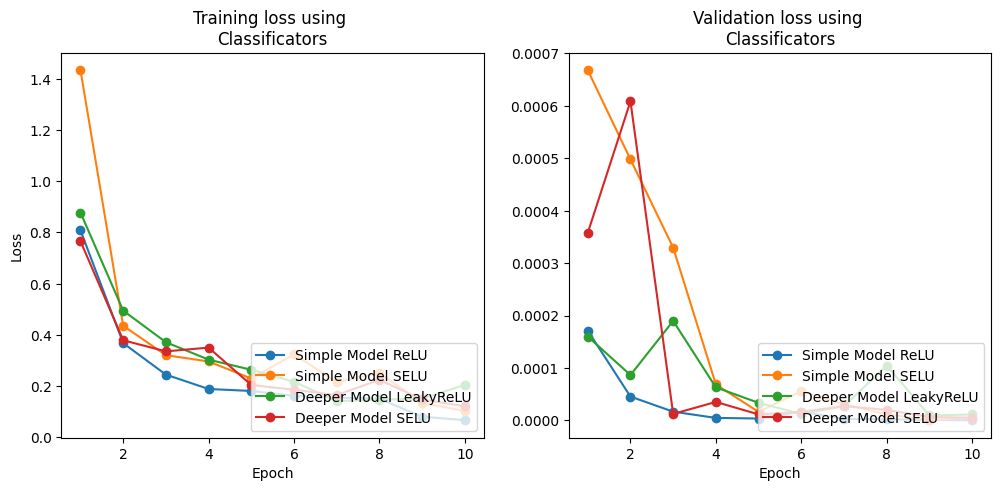

In [18]:
info = {
    'Simple Model ReLU': simple_model_with_relu_dic,
    'Simple Model SELU': simple_model_with_selu_dic,
    'Deeper Model LeakyReLU': deeper_model_with_leakyrelu_dic,
    'Deeper Model SELU': deeper_model_with_selu_dic
}

plot_metric_from_array(info, '\nClassificators')
plot_metric_from_array(info, '\nClassificators', metric='loss')